In [29]:
import logging
import pandas as pd
import numpy as np
from numpy import random
import gensim
import nltk
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
import re
from bs4 import BeautifulSoup
%matplotlib inline

In [30]:
df = pd.read_csv('gst_data1.csv', encoding='unicode_escape')

In [31]:
df = df[pd.notnull(df['Type'])]
print(df.tail())


                                                   Data             Type
1472  Some survivors are denied access to mail by th...  Not filling Gst
1473  Sometimes IRS continues to send mail to the ad...  Not filling Gst
1474  The ILS Low Income Taxpayer Clinic is proud to...  Not filling Gst
1475  Indiana Legal Services uses the law to fight p...  Not filling Gst
1476  Please consider donating to Indiana Legal Serv...  Not filling Gst


In [32]:
def print_plot(index):
    example  = df[df.index == index][df.columns].values[0]
    if len(example) > 0:
        print(example[0])
        print('Tag:', example[1])
print_plot(4)

Red flags of false invoices:

No receiving report for invoiced goods or services
Invoiced goods or services cannot be located in inventory or accounted for
No purchase order for invoiced goods or services
Quantities, pricing amounts or other numbers on invoices do not match Benfords Law distributions
Tag: Fake Invoice Numbers


In [33]:
#preprocessing text data
#replace [/(){}\[\]\|@,;] by space ' '
#remove stopwords
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')   
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))

def clean_text(txt):
    txt = BeautifulSoup(txt, "lxml").text # HTML decoding
    txt = txt.lower() # lowercase text
    txt = REPLACE_BY_SPACE_RE.sub(' ', txt) # replace REPLACE_BY_SPACE_RE symbols by space in text
    txt = BAD_SYMBOLS_RE.sub('', txt) # delete symbols which are in BAD_SYMBOLS_RE from text
    txt = ' '.join(word for word in txt.split() if word not in STOPWORDS) # delete stopwors from text
    return txt

In [54]:
df = df.dropna()
print("shape : {}".format(df.shape))

shape : (1472, 2)


In [36]:
df['Data'] = df['Data'].apply(clean_text)

C:\Users\Loveprit\Anaconda3\lib\site-packages\bs4\__init__.py:335: UserWarning: "https://economictimes.indiatimes.com/news/economy/finance/promoters-arrested-as-tax-officials-raid-companies-suspected-of-circular-trade/articleshow/68278958.cms?utm_source=contentofinterest&utm_medium=text&utm_campaign=cppst" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup


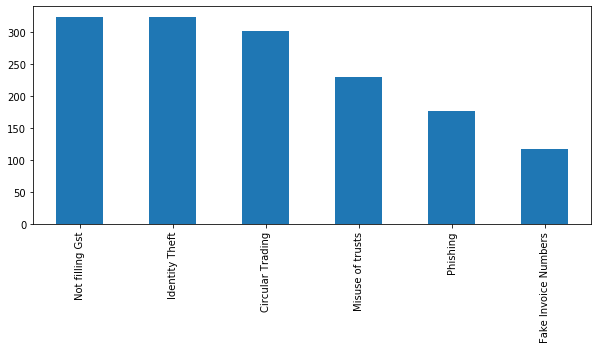

In [52]:
plt.figure(figsize=(10,4))
df.Type.value_counts().plot(kind='bar');

Type of fault          Count
Not filling Gst         324
Identity Theft          323
Circular Trading        302
Misuse of trusts        230
Phishing                176
Fake Invoice Numbers    117
Name: Type, dtype: int64


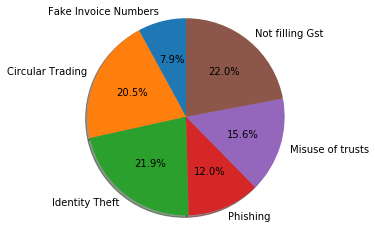

In [63]:
my_tags = df['Type'].unique().tolist()
print("Type of fault          Count")
print(df['Type'].value_counts())
sizes = [117,302,323,176,230,324]

fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=my_tags, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

In [38]:
X = df.Data
y = df.Type
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state  = 40)

In [39]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer

nb = Pipeline([('vect', CountVectorizer()),
               ('tfidf', TfidfTransformer()),
               ('clf', MultinomialNB()),
              ])
nb.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('vect',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=None)),
                ('tfidf',
                 TfidfTransformer(norm='l2', smooth_idf=True,
                                  sublinear_tf=False, use_idf=True)),
                ('clf',
                 MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))],
         verbose=False)

In [40]:
from sklearn.metrics import classification_report
y_pred = nb.predict(X_test)

print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred,target_names=my_tags))

accuracy 0.5769230769230769
                      precision    recall  f1-score   support

Fake Invoice Numbers       0.53      0.60      0.56        84
    Circular Trading       1.00      0.35      0.52        37
      Identity Theft       0.51      0.76      0.61        95
            Phishing       0.98      0.55      0.70        88
    Misuse of trusts       0.40      0.58      0.47        81
     Not filling Gst       1.00      0.44      0.61        57

            accuracy                           0.58       442
           macro avg       0.74      0.54      0.58       442
        weighted avg       0.69      0.58      0.59       442



In [42]:
#linear_svm
from sklearn.linear_model import SGDClassifier

sgd = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', SGDClassifier(loss='hinge', penalty='l2',alpha=1e-3, max_iter=5, tol=None)),
               ])
sgd.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('vect',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=Non...
                ('clf',
                 SGDClassifier(alpha=0.001, average=False, class_weight=None,
                               early_stopping=False, epsilon=0.1, eta0=0.0,
                               fit_intercept=True, l1_ratio=0.15,
                               learning_rate='optimal', loss='hinge',
                      

In [55]:
%%time

y_pred = sgd.predict(X_test)

print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred,target_names=my_tags))

accuracy 0.7217194570135747
                      precision    recall  f1-score   support

Fake Invoice Numbers       0.60      0.60      0.60        84
    Circular Trading       0.94      0.81      0.87        37
      Identity Theft       0.66      0.77      0.71        95
            Phishing       0.93      0.77      0.84        88
    Misuse of trusts       0.52      0.57      0.54        81
     Not filling Gst       0.93      0.91      0.92        57

            accuracy                           0.72       442
           macro avg       0.76      0.74      0.75       442
        weighted avg       0.74      0.72      0.73       442

Wall time: 21 ms


In [44]:
#Logistic regression
from sklearn.linear_model import LogisticRegression

logreg = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', LogisticRegression(n_jobs=1, C=1e5)),
               ])
logreg.fit(X_train, y_train)

C:\Users\Loveprit\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Loveprit\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


Pipeline(memory=None,
         steps=[('vect',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=None)),
                ('tfidf',
                 TfidfTransformer(norm='l2', smooth_idf=True,
                                  sublinear_tf=False, use_idf=True)),
                ('clf',
                 LogisticRegression(C=100000.0, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=

In [45]:
%%time

y_pred = logreg.predict(X_test)

print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred,target_names=my_tags))

accuracy 0.6877828054298643
                      precision    recall  f1-score   support

Fake Invoice Numbers       0.59      0.61      0.60        84
    Circular Trading       0.94      0.81      0.87        37
      Identity Theft       0.68      0.66      0.67        95
            Phishing       0.97      0.70      0.82        88
    Misuse of trusts       0.42      0.60      0.50        81
     Not filling Gst       0.96      0.86      0.91        57

            accuracy                           0.69       442
           macro avg       0.76      0.71      0.73       442
        weighted avg       0.73      0.69      0.70       442

Wall time: 22.9 ms
